In [66]:
# Library importation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Part 1 : data loading

In [68]:
# Dataframe importation
df = pd.read_csv('productos_vendidos.csv')
df.head()

,Unnamed: 0,ITEM_CODE,TOTAL_UNIT_SALES,TOTAL_VALUE_SALES,TOTAL_UNIT_AVG_WEEKLY_SALES,REGION,MANUFACTURER,BRAND,ITEM_DESCRIPTION,FORMAT,ATTR1,ATTR2,ATTR3,ID_CATEGORY,CATEGORY,WEEK,YEAR,MONTH,WEEK_NUMBER,DATE
0,0,7501058792808BP2,0.006,0.139,1.000,5,RECKITT,VANISH,VANISHOXIACTIONROSADOYPACK120GR+MMCRYSTALWHITE...,POLVO,SAFE BLEACH,FABRIC TREATMENT,ROSA,1,FABRIC TREATMENT AND SANITIZER,34-22,2022,8,34,2022-08-28
1,1,7501058715883,0.487,116.519,2.916,5,RECKITT,VANISH,VANISH OXI ACTION GOLD QUITAMANCHAS BOLSA 1.8K...,POLVO,SAFE BLEACH,FABRIC TREATMENT,ROSA,1,FABRIC TREATMENT AND SANITIZER,34-22,2022,8,34,2022-08-28
2,2,7702626213774,1.391,68.453,5.171,5,RECKITT,VANISH,VANISH OXI ACTION ROSA QUITAMANCHAS DOYPACK 24...,POLVO,SAFE BLEACH,FABRIC TREATMENT,ROSA,1,FABRIC TREATMENT AND SANITIZER,34-22,2022,8,34,2022-08-28
3,3,7501058716422,0.022,1.481,1.833,5,RECKITT,VANISH,VANISH OXI ACTION GOLD QUITAMANCHA AHORRO DEL ...,POLVO,SAFE BLEACH,FABRIC TREATMENT,ROSA,1,FABRIC TREATMENT AND SANITIZER,34-22,2022,8,34,2022-08-28
4,4,7501058784353,2.037,182.839,5.375,5,RECKITT,VANISH,VANISH INTELLIGENCE POLVO BOTE 450 GR NAL 7501...,POLVO,SAFE BLEACH,FABRIC TREATMENT,ROSA,1,FABRIC TREATMENT AND SANITIZER,34-22,2022,8,34,2022-08-28


# Part 2: data visualization and model selection

<Axes: xlabel='DATE'>

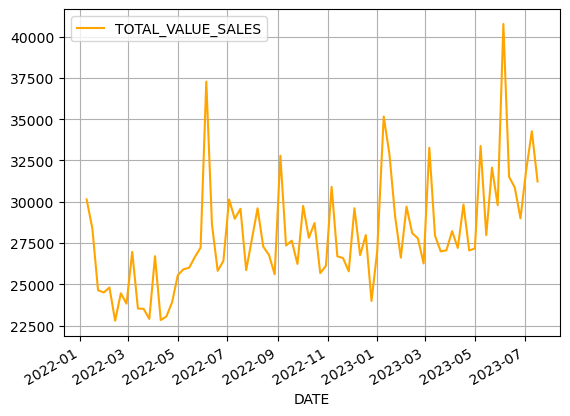

In [70]:
# Data filtration by BRAND (Vanish and Lysol*
productos_reckitt = ['VANISH','LYSOL']
df = df[df['BRAND'].isin(productos_reckitt)]


# Date unit transformation
df['DATE'] = pd.to_datetime(df['DATE'])

# Grouping by DATE
df= df.groupby(['DATE']).agg({'TOTAL_VALUE_SALES':'sum'})

# General plot of total value sales in time
df.plot(grid=True, color='orange')

In [71]:
# Importation of adfuller to use Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

# adfuller implementation
# H0 : NO stationary series
# Ha: Stationary series
result = adfuller(df)
print('p-value= ', result[1])
if result[1] < 0.05: 
    print('We reject H0, the series is stationary')
else:
    print('We cant reject H0, the series is not stationary')

p-value=  0.7808518003630399
We cant reject H0, the series is not stationary


Since the series is not stationary, we will calculate differences to series. But first, we will divide data on train and test data. 

# Part 3 : definition of train and test data

In [74]:
# Size definition of train and test data
len_train = int(len(df)*0.6)
len_test = int(len(df)*0.4)

# Definition of train and test data
train = df[:len_train]
test = df[len_train:]

# Part 4: Model construction and training

p-value=  0.02452915191052531
We reject H0, the series is stationary


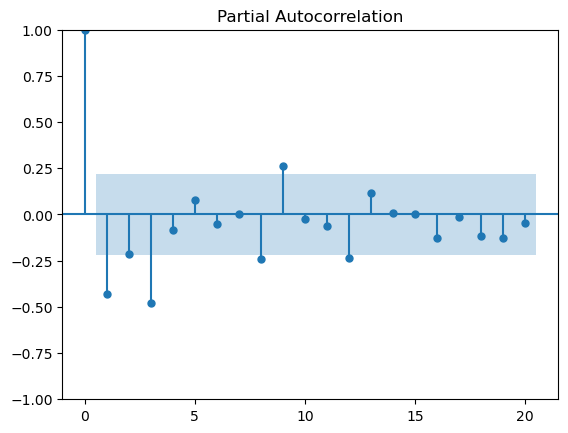

In [76]:
# Diferences calculation 
df['diferencias_1'] = df['TOTAL_VALUE_SALES'].diff()

#  Drop of NA values
df = df.dropna()

# Dickey-fuller test on series with diferences calculation
result = adfuller(df['diferencias_1'])
print('p-value= ', result[1])

if result[1] < 0.05: 
    print('We reject H0, the series is stationary')
else:
    print('We cant reject H0, the series is not stationary')

# Partial autocorelation to obtain p optimal va lue
from statsmodels.graphics.tsaplots import plot_pacf

# ploting of PACF
plot_pacf(df['diferencias_1'], lags=20, alpha=0.05)
plt.show()

In [77]:
# Importation of ARIMA module to estimate AIC
from statsmodels.tsa.arima.model import ARIMA
lista= []
for p in range (1,4): # iteration to find p optimal value
    for q in range (1,4): # q optimal value
        for d in range (1,2):
            mod_ar = ARIMA(df['diferencias_1'], order=(p,d,q)) # ARIMA object
            res_ar = mod_ar.fit() # Model aplication
            lista.append(res_ar.aic)
            try:
                print(f'AIC for ARIMA({p},{d},{q}) es: {res_ar.aic}')
            except Exception as e:
                print(f'Error ARIMA({p},1,{q}): {e}')
# List sorting
lista.sort()

# Let's drop the column diferencias_1
df.drop(columns='diferencias_1', inplace=True)
lista

AIC for ARIMA(1,1,1) es: 1494.1131496833377
AIC for ARIMA(1,1,2) es: 1481.2716959983861
AIC for ARIMA(1,1,3) es: 1481.351866186811
AIC for ARIMA(2,1,1) es: 1492.9202777505338
AIC for ARIMA(2,1,2) es: 1494.4187461560534
AIC for ARIMA(2,1,3) es: 1483.9881518427444
AIC for ARIMA(3,1,1) es: 1474.4103954361237
AIC for ARIMA(3,1,2) es: 1475.815520782338
AIC for ARIMA(3,1,3) es: 1478.6962534869217


[1474.4103954361237,
 1475.815520782338,
 1478.6962534869217,
 1481.2716959983861,
 1481.351866186811,
 1483.9881518427444,
 1492.9202777505338,
 1494.1131496833377,
 1494.4187461560534]

In [78]:
# Let's use ARIMA (3,1,1) using train data
model = ARIMA(train['TOTAL_VALUE_SALES'], order=(3,1,1))
res = model.fit()

# Predicciones using test data
predicciones = res.forecast(len(test)) # predicciones correspondientes a la base de prueba
predicciones = predicciones.reset_index()
predicciones.drop('index', axis=1, inplace=True)

 # Confidence intervals calculation using alpha=0.05
conf = res.get_forecast(len(test)).conf_int(alpha=0.05)
conf = conf.reset_index()
conf.drop('index', axis=1, inplace=True)

# Index asignation to dataframes predicciones and conf
test = test.reset_index()
date = test['DATE']
date = pd.DataFrame(date) # este dataframe con las fechas se va a concatenar con predicciones y conf

# Index asignation to database conf
conf = pd.concat([date, conf], axis=1)
conf.index = conf['DATE']
conf = conf.drop('DATE', axis=1)

# Index asignation to predicciones database
predicciones = pd.concat([date, predicciones], axis=1)
predicciones.index = predicciones['DATE']
predicciones = predicciones.drop('DATE', axis=1)


test = df[len_train:]

# Part 5: Model validation

In [80]:
#  RMSE and MAPE calculation
import numpy as np
acumulador1 = 0 # for mse calculation
acumulador2 = 0 # for mape calculation

for contador in range(0,31):#
    acumulador1 = acumulador1 + (test.iloc[contador] - predicciones.iloc[contador][0]) ** 2
    acumulador2 = acumulador2 + (np.abs((test.iloc[contador] - predicciones.iloc[contador][0]) / test.iloc[contador]))

mse = acumulador1 / 31
rmse = np.round(np.sqrt(mse),2)
mape = np.round((acumulador2 / 31)*100,2)
print('RMSE =', float(rmse), 'MAPE =', float(mape))

RMSE = 3724.72 MAPE = 7.98


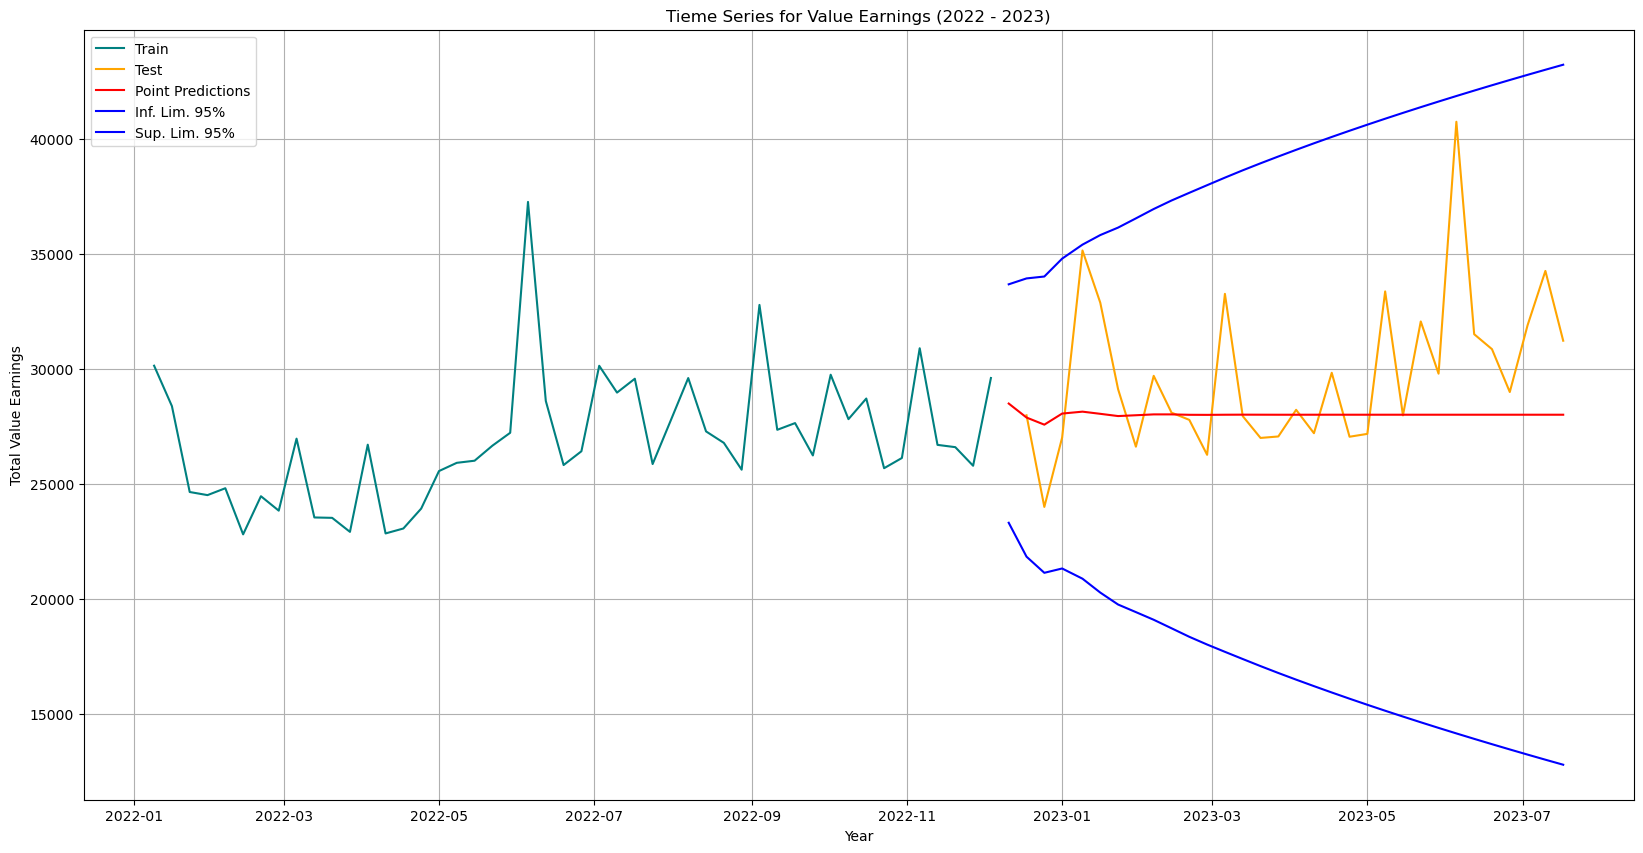

In [81]:
# Plotting
plt.figure(figsize=(20,10))
plt.grid() # Agregar cuadricula
plt.plot(train,label='Train', color='teal' ) # datos de entrenamiento
plt.plot(test, label = 'Test', color='orange') # datos de prueba
plt.plot (predicciones, label = 'Point Predictions', color = 'red') # datos de predicciones
#plt.plot(df['Average'].iloc[134:136], label = 'Test', color='orange') # esta linea la coloque porque quedaba un gap en la grafica, a pesar de verificar que se incluyeran todos los datos entre la base de prueba y entrenamiento
plt.plot (conf['lower TOTAL_VALUE_SALES'], label = 'Inf. Lim. 95%', color = 'blue') #intervalo superior
plt.plot (conf['upper TOTAL_VALUE_SALES'], label = 'Sup. Lim. 95%', color = 'blue') # intervalo inferior
plt.title('Tieme Series for Value Earnings (2022 - 2023)')
plt.ylabel('Total Value Earnings')
plt.xlabel('Year')
plt.legend(loc='best')
plt.savefig('timeseries_reckitt.png')

# Part 6 : Future Predictions for next 8 periods (weeks in this case)

In [147]:
# Size definition of train and test data
len_train = int(len(df)*0.6)
len_test = int(len(df)*0.4)

# Definition of train and test data
train = df[:len_train]
test = df[len_train:]

# Let's use ARIMA (3,1,1)
model = ARIMA(train['TOTAL_VALUE_SALES'], order=(3,1,1))
res = model.fit()

# Predictions for next 8 periods
predicciones = res.forecast(len(test)+8) 
predicciones = predicciones.tail(8) 
predicciones = predicciones.reset_index()
predicciones.drop('index', axis=1, inplace=True)


# Incorporation of additional dates to dataframe
predicciones['DATE'] = ['2023-07-24', '2023-07-31', '2023-08-07', '2023-08-14', '2023-08-21', '2023-08-28', '2023-09-04', '2023-09-11']
predicciones['DATE'] = pd.to_datetime(predicciones['DATE'])
predicciones = predicciones.set_index('DATE')
predicciones = predicciones.rename(columns={'predicted_mean':'predicciones_puntuales'})


# Confidence Intervals with alpha 0.05
conf = res.get_forecast(len(test)+8).conf_int(alpha=0.05)
conf = conf.reset_index()
conf.drop('index', axis=1, inplace=True)
conf = conf.tail(8)
conf['DATE'] = ['2023-07-24', '2023-07-31', '2023-08-07', '2023-08-14', '2023-08-21', '2023-08-28', '2023-09-04', '2023-09-11']
conf['DATE'] = pd.to_datetime(conf['DATE'])
conf = conf.set_index('DATE')

# Merging of dataframe prediction and conf
df_p = pd.concat([predicciones, conf], axis=1)

# Renaming of columns
df_p = df_p.rename(columns={'predicted_mean':'predicciones_puntuales', 'lower TOTAL_VALUE_SALES':'limite_inferior', 'upper TOTAL_VALUE_SALES':'limite_superior'})
df_p

,predicciones_puntuales,limite_inferior,limite_superior
DATE,,,
2023-07-24,27976.167159,14779.711210,41172.623108
2023-07-31,27976.167142,14599.714133,41352.620151
2023-08-07,27976.167083,14422.107161,41530.227004
2023-08-14,27976.167072,14246.797631,41705.536514
2023-08-21,27976.167091,14073.698599,41878.635582
2023-08-28,27976.167100,13902.728459,42049.605741
2023-09-04,27976.167096,13733.810541,42218.523651
2023-09-11,27976.167091,13566.872686,42385.461497


# Conclusion :
De acuerdo al modelo ARIMA (3,1,1), se obtuvo un modelo con un  un RMSE de 3748 unidades y un MAPE del 8%, sugiriendo que el modelo es adecuado para predecir las ganancias futuras de productos VANISH y LYSOL.

De acuerdo a las proyecciones, se estima que se estima que el valor total generado sea de 28048 unidades en los próximos meses. 